# 9. Modelos de cambio de régimen en base a Cadenas de Markov

Observemos la evolución del PIB trimestral para Bolivia.

In [2]:
setwd("..")

In [4]:
if (!file.exists("./Datos/PIBTrim.xlsx")) {
    url <- "https://nube.ine.gob.bo/index.php/s/I0Wq5MdeiEwdZEC/download"
    download.file(url, destfile = "./Datos/PIBTrim.xlsx", mode = "wb")
}

In [5]:
library(readxl)

In [6]:
pib <- read_xlsx("./Datos/PIBTrim.xlsx", sheet = 1, range = "A10:H163")

In [8]:
datos <- data.frame(Fecha = pib[, 1], pib = pib[, 8])

In [17]:
colnames(datos) <- c("Fecha", "PIB")

In [43]:
filas <- which(datos$Fecha == "I   Trimestre" | datos$Fecha == "II  Trimestre" | 
               datos$Fecha == "III Trimestre" | datos$Fecha == "IV Trimestre")

In [45]:
datos <- datos[filas, ]

In [47]:
datos$Fecha <- seq(as.Date("01-01-1990", "%d-%m-%Y"), as.Date("01-04-2020", "%d-%m-%Y"), by = "quarter")

In [48]:
head(datos)

,Fecha,PIB
,<date>,<dbl>
2,1990-01-01,3587595
3,1990-04-01,3926068
4,1990-07-01,3934133
5,1990-10-01,3995340
7,1991-01-01,3677806
8,1991-04-01,4217984


In [49]:
tail(datos)

,Fecha,PIB
,<date>,<dbl>
147,2019-01-01,11316218
148,2019-04-01,12506583
149,2019-07-01,12490126
150,2019-10-01,12944005
152,2020-01-01,11379577
153,2020-04-01,9795505


In [50]:
library(ggplot2)

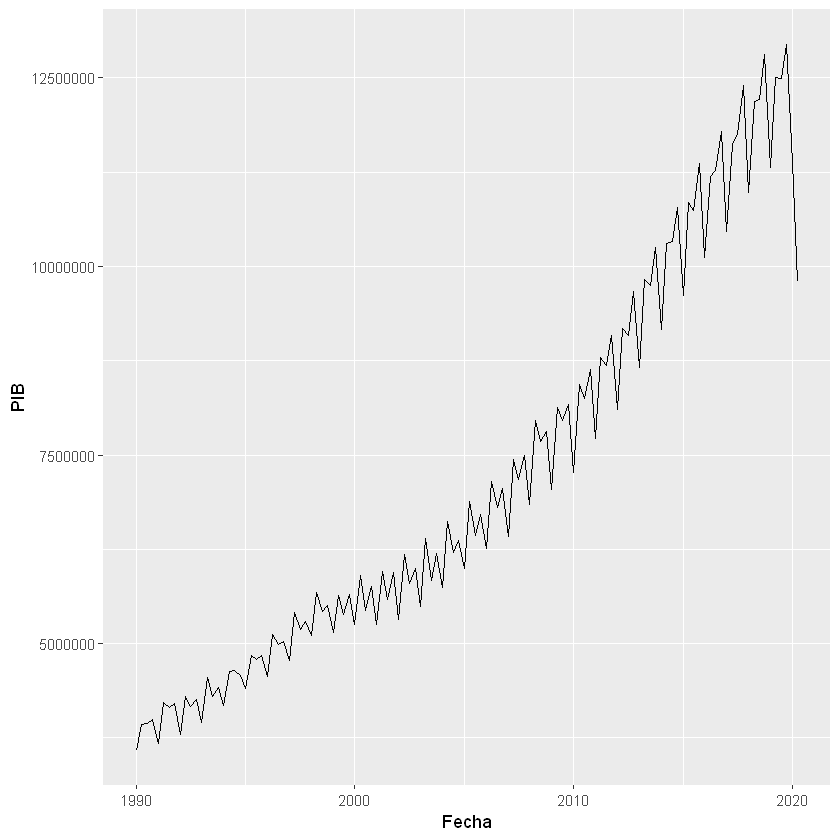

In [51]:
g <- ggplot(data = datos, aes(x = Fecha, y = PIB))
g + geom_line()

In [71]:
pib <- ts(datos$PIB, start = c(1990,1), end = c(2020, 2), frequency = 4)

In [72]:
descom <- stl(pib, s.window = 9, s.degree = 1, t.window = 9, t.degree = 1)

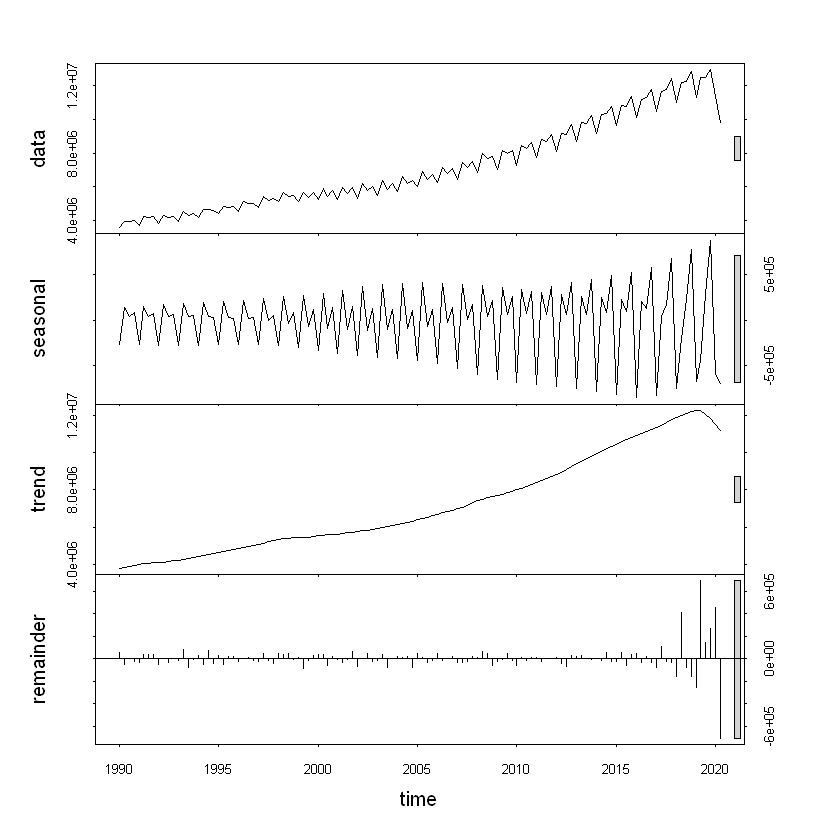

In [73]:
plot(descom)

In [74]:
pib_us <- pib - descom$time.series[, 1]

In [76]:
datos$pib_us <- as.numeric(pib_us)

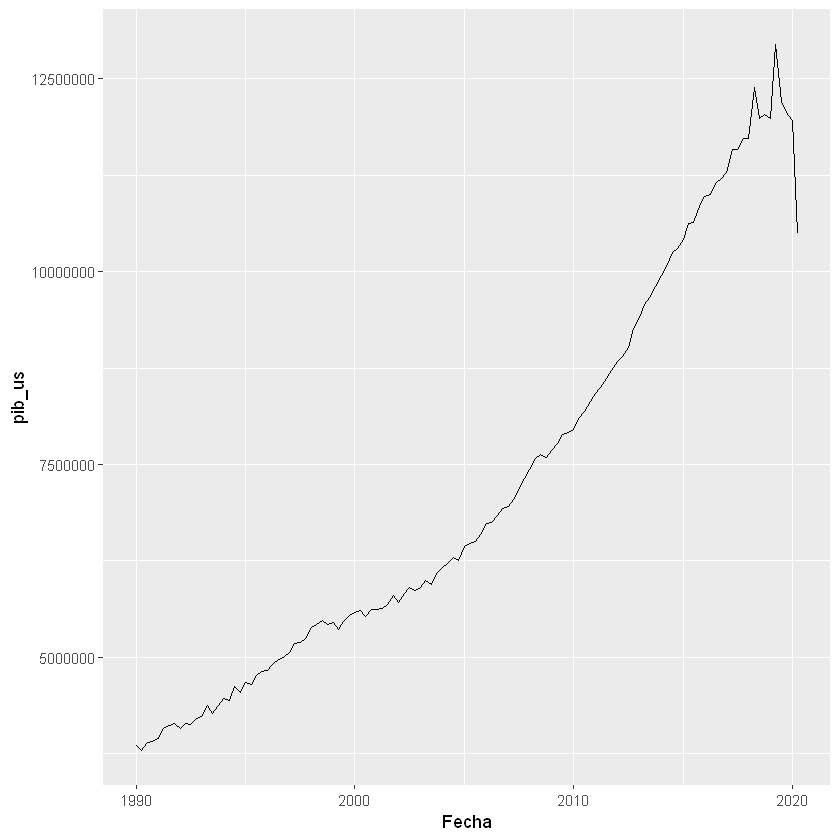

In [77]:
g <- ggplot(data = datos, aes(x = Fecha, y = pib_us))
g + geom_line()

In [78]:
n <- nrow(datos)

In [83]:
datos_mod <- datos[1:(n - 10), ]

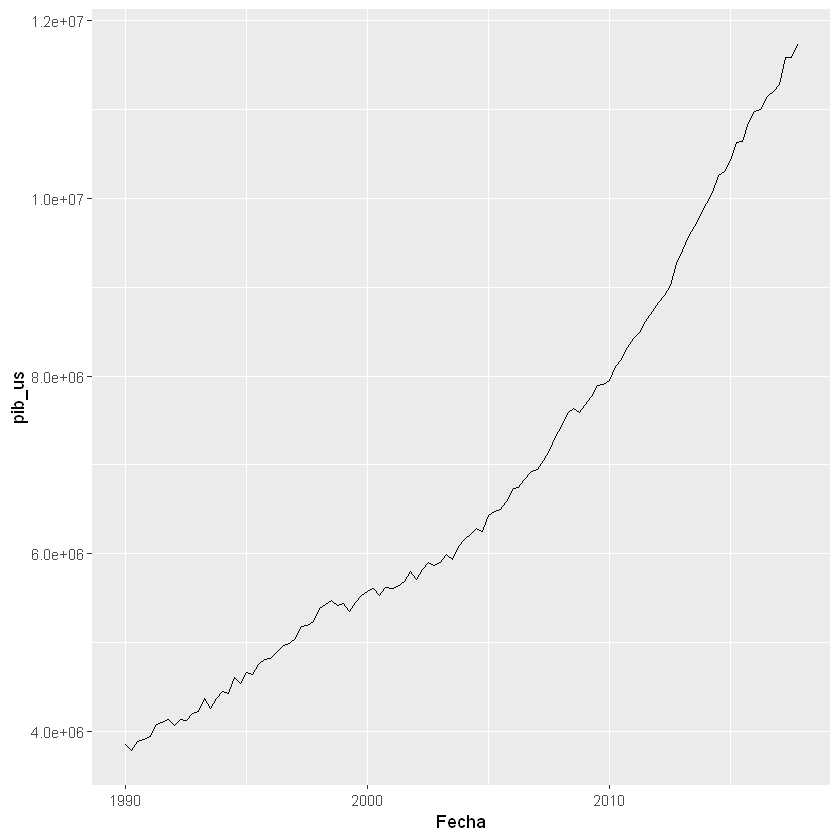

In [84]:
g <- ggplot(data = datos_mod, aes(x = Fecha, y = pib_us))
g + geom_line()

In [89]:
datos_mod$crec <- c(NA, (datos_mod$pib_us[2:112] / datos_mod$pib_us[1:111] - 1) * 100)

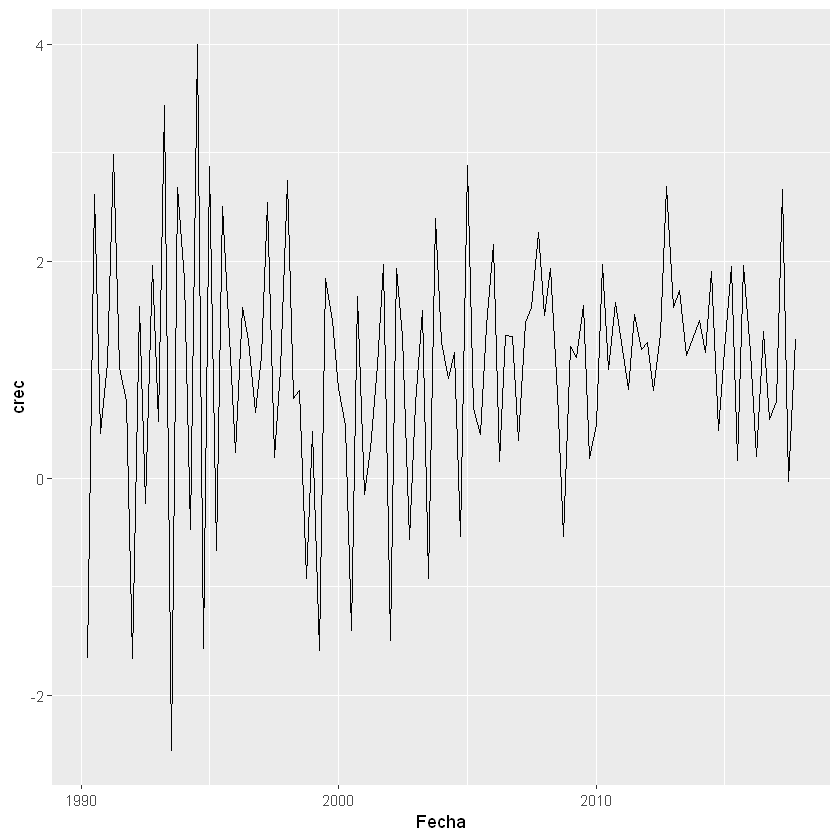

In [91]:
g <- ggplot(data = datos_mod[2:112, ], aes(x = Fecha, y = crec))
g + geom_line()

A pesar que el gráfico contiene algo de ruido pueden identificarse periodos donde el crecimiento trimestral del PIB estaba más bajo por ejemplo finales de la década de los 90 y periodos de auge donde hay mayores niveles de crecimiento del PIB trimestral por ejemplo a partir de 2005 a 2015. Entonces podríamos formar la hipótesis que el crecimiento Trimestral del PIB de Bolivia sigue un proceso AR(p) con las siguientes características:

$$y_t = \left\{\begin{array}{l} c_1 + \phi^{(1)}_1 y_{t - 1} + \phi^{(1)}_2 y_{t - 2} + \dots + \phi^{(1)}_p y_{t - p} + \epsilon_{1t} \text{ cuando } s_t = 1\\
 c_2 + \phi^{(2)}_1 y_{t - 1} + \phi^{(2)}_2 y_{t - 2} + \dots + \phi^{(2)}_p y_{t - p} + \epsilon_{2t} \text{ cuando } s_t = 2 \end{array}\right.$$

donde $\epsilon_{it}$ para $i = 1, 2$ es un proceso ruido blanco gausiano con media 0 y varianza $\sigma^2_i$. El estar o no en cualquiera de los procesos depende de la realización del proceso estocástico $s_t$ que es no observable y toma los valores discretos de 1 cuando la economía está en recesión y de 2 cuando la economía está en auge. A este modelo se lo denomina modelo autoregresivo con cambio de régimen, Adicionalmente se considera que el cambio de régimes está determinado por una cadena de Markov. Entonces el primer paso para entender estos modelos es entender las cadenas de Markov.

### 9.1 Cadenas de Markov

Consideremos una variable aleatoria $s_t$ que puede asumir solamente valores enteros: $1, 2, \dots, N$. Supongamos que la probabilidad de que $s_t$ sea igual a un valor particular $j$ depende solamente del valor reciente $s_{t - 1}$, es decir:

$$P[s_t = j | s_{t - 1} = i, s_{t - 2} = k, \dots] = P[s_t = j | s_{t - 1} = i] = p_{ij}$$

Tal proceso está descrito como una **cadena de Markov de N-estados** con probabilidades de transición $\{p_{i,j}\}_{i, j = 1, 2, \dots, N}$. Además deben cumplir que:

$$\sum^N_{j = 1}p_{ij} = 1$$

Podemos ubicar todas las probabilidades de transición en una matriz que se conoce como la **matriz de transición** $\mathbf{P}$:

$$\mathbf{P} = \left[\begin{array}{cccc}p_{11} & p_{21} & \dots & p_{N1} \\
                                        p_{12} & p_{22} & \dots & p_{N2} \\
                                        \vdots & \vdots & \ddots & \vdots \\
                                        p_{1N} & p_{2N} & \dots & p_{NN}\end{array}\right]$$
                                        
donde se debe cumplir que la suma de cada columna sea 1.

Puede representarse una cadena de Markov como un vector autoregresivo. Para ello denotemos a $\mathbf{\xi}_t$ un vector de tamaño $N \times 1$ donde su j-ésimo elemento es 1 si $s_t = 1$ y todos sus demás elementos son iguales a 0. Entonces $\mathbf{\xi}_t$ es la primera columna de la matriz identidad $\mathbf{I}_N$. Cuando $s_t = 2$, entonces $\mathbf{\xi}_t$ es la segunda columna de la matriz identidad $\mathbf{I}_N$ y asi seguimos sucesivamente hasta completar todos los estados.

Definamos:

$$E(\mathbf{\xi}_{t + 1}|s_t = i) = \left[\begin{array}{c} p_{i1} \\
                                                           p_{i2} \\
                                                           \vdots \\
                                                           p_{iN}\end{array}\right]$$

Este vector no es nada más que la i-ésima columna de la matriz $\mathbf{P}$. Como $\mathbf{\xi}_t$ es igual a la i-ésima columna de la matriz $\mathbf{I}_N$, tenemos que:

$$E(\mathbf{\xi}_{t+1}|\mathbf{\xi}_t) = \mathbf{P}\mathbf{\xi}_t$$

Lo que implica que:

$$\mathbf{\xi}_{t + 1} = \mathbf{P}\mathbf{\xi}_t + \mathbf{v}_{t + 1}$$

donde $\mathbf{v}_{t + 1}$ es un proceso martingala en diferencias. 

Con esta representación podemos hallar el pronóstico $\mathbf{\hat{\xi}}_{t + m|t}$ como:

$$\mathbf{\hat{\xi}}_{t + m|t} = \hat{E}(\mathbf{\hat{\xi}}_{t + m}|\mathbf{\xi}_t, \mathbf{\xi}_{t - 1}, \dots) = \mathbf{P}^m \mathbf{\xi}_t$$.

Lo que representa el j-ésimo elemento de este vector $\mathbf{\hat{\xi}}_{t + m|t}$ es la probabilidad de que $s_{t + m} = j$ dado que $s_t = i$. Entonces $\mathbf{P}^m$ nos da las probabilidades de transicion $m$ periodos adelante.

Un concepto que se maneja es el de cadenas de markov ergódicas. Para ello se define un vector de probabilidades ergódicas $\mathbf{\pi}$ y este vector debe satisfacer el requerimiento que:

$$\mathbf{P \pi} = \mathbf{\pi}$$

lo que muestra que $\mathbf{\pi}$ es el autovector relacionado con el autovalor de $\mathbf{P}$ igual a 1. Se puede demostrar que:

$$\lim_{m \to \infty} \mathbf{P}^m = \mathbf{\pi 1'}$$

Resulta que el pronóstico de largo plazo es $\mathbf{\pi}$ y también es la media no condicional del proceso.

Una cadena de Markov ergódica es entonces un proceso estacionario.

### 9.2 Análisis estadístico de combinación de distribuciones para variables i.i.d

Supongamos que tenemos el proceso:

$$y_t = \left\{\begin{array}{l}\mu_1 + \epsilon_{1t} \text{ cuando } s_t = 1 \\
                               \mu_2 + \epsilon_{2t} \text{ cuando } s_t = 2 \\
                               \vdots \\
                               \mu_N + \epsilon_{Nt} \text{ cuando } s_t = N\end{array}\right.$$

donde $\epsilon_{jt} \sim N(0, \sigma^2_j)$ para $j = 1, 2, \dots, N$. Tenemos que la función de densidad condicional de $y_t$ respecto a la variable aleatoria $s_t$ es:

$$f(y_t|s_t = j; \mathbf{\Theta}) = \frac{1}{\sqrt{2 \pi \sigma^2_j}}exp\left[\frac{-(y_t - \mu_j)^2}{2 \sigma^2_j} \right]$$

La variable $s_t$ no es observable pero sabemos que la probabilidad no condicional de que $s_t = j$ es:

$$P[s_t = j; \mathbf{\Theta}] = \pi_j$$

La probabilidad conjunta de $y_t$ y $s_t$ sería:

$$p(y_t, s_t = j; \mathbf{\Theta}) = \frac{\pi_j}{\sqrt{2 \pi \sigma^2_j}}exp\left[\frac{-(y_t - \mu_j)^2}{2 \sigma^2_j} \right]$$

De esta forma la función de densidad no condicional de $y_t$ sería:

$$f(y_t; \mathbf{\Theta}) = \sum^N_{j = 1}p(y_t, s_t = j; \mathbf{\Theta})$$

Finalmente la función de verosimilitud en logaritmos sería:

$$\mathcal{L}(\mathbf{\Theta}) = \sum^T_{t = 1} \log f(y_t; \mathbf{\Theta})$$

Se pueden seguir los siguientes pasos para la estimación:

1. Darse un valor inicial de $\mathbf{\Theta}_0$.
2. Calcular $\pi_j$.
3. Usar todos las $\pi_j$ para maximizar la función de verosimilitud y hallar un nuevo $\mathbf{\Theta}_1$.
4. Repetir los pasos 2 y 3 hasta que se cumpla un criterio de convergencia.

Podemos adicionalmente una vez obtenidos los parámetros del modelo $\mathbf{\hat{\Theta}}$ calcular:

$$P[s_t = j|y_t;\mathbf{\hat{\Theta}}] = \frac{\pi_j f(y_t|s_t = j; \mathbf{\hat{\Theta}})}{f(y_t; \mathbf{\hat{\Theta}})}$$

que no es más que la probabilidad de estar en el estado $j$ dada la observación $y_t$ y el conjunto de parámetros estimados $\mathbf{\hat{\Theta}}$.

La estructura es similar para el caso de procesos autoregresivos y puede verse en Hamilton(1994).

### 9.3 Caso de Estudio: Modelo Autoregresivo con Cambio de Régimen en base a Cadenas de Markov aplicado al crecimiento trimestral de Bolivia 1990 - 2017

In [92]:
library("MSwM")

Loading required package: parallel



In [93]:
ols_mod <- lm(crec ~ 1, data = datos_mod)

In [95]:
ms_mod <- msmFit(ols_mod, k = 2, sw = c(TRUE, TRUE, TRUE), p = 1)

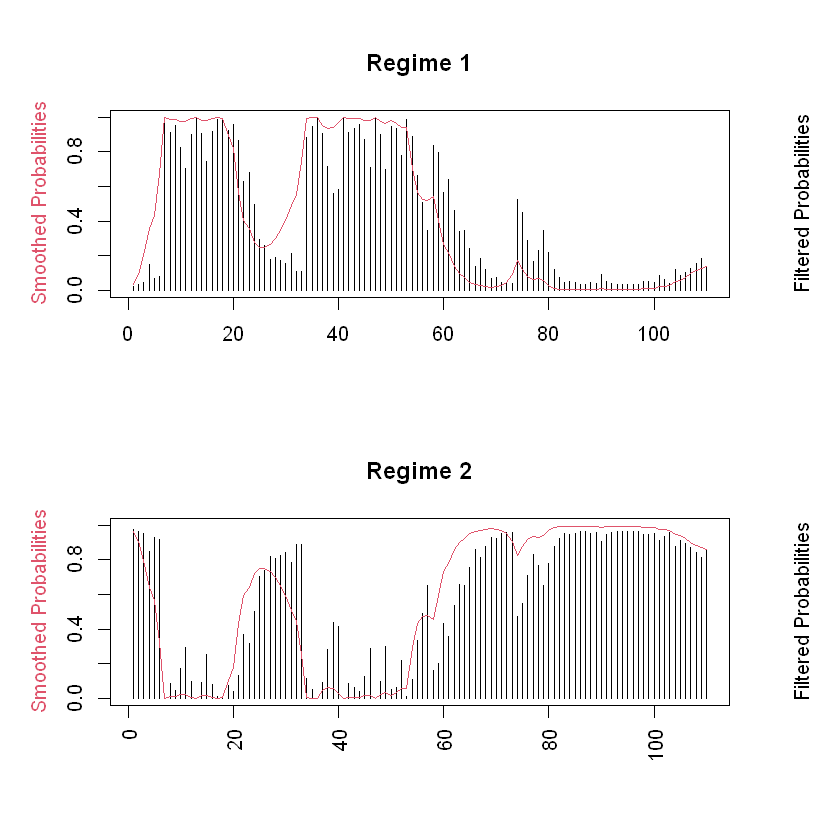

In [98]:
plotProb(ms_mod, which = 1)

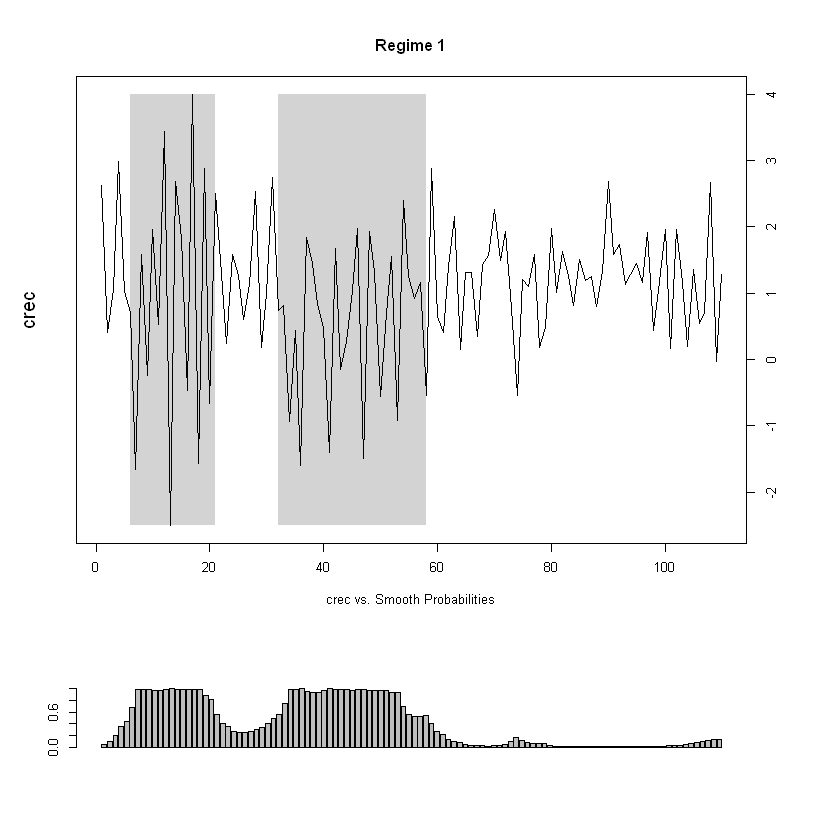

In [99]:
plotProb(ms_mod, which = 2)

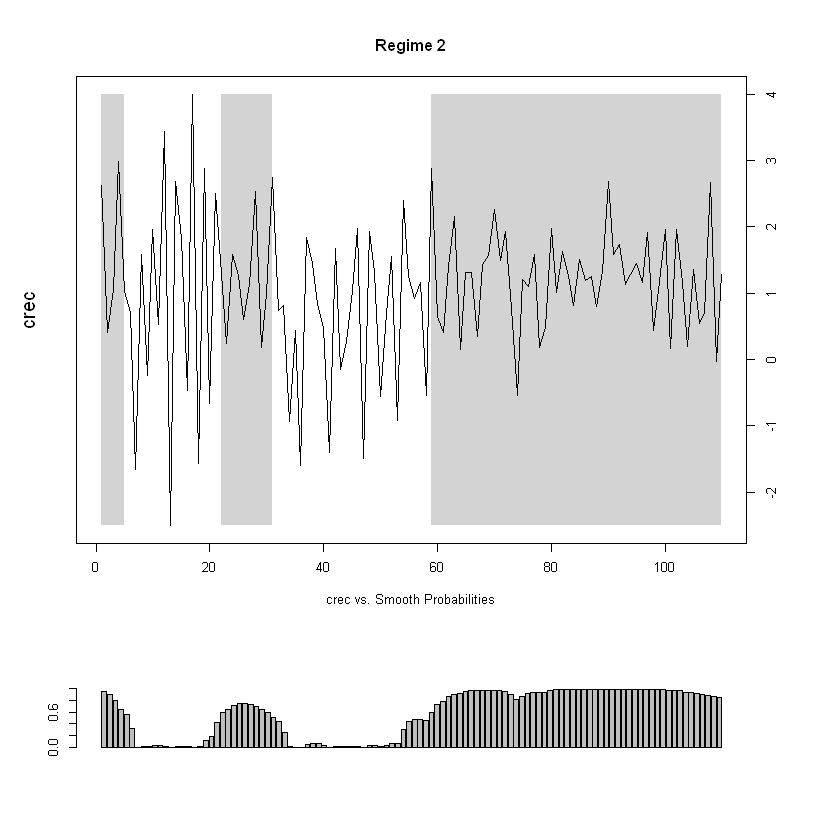

In [100]:
plotProb(ms_mod, which = 3)

In [102]:
summary(ms_mod)

Markov Switching Model

Call: msmFit(object = ols_mod, k = 2, sw = c(TRUE, TRUE, TRUE), p = 1)

       AIC      BIC    logLik
  309.1668 338.7707 -150.5834

Coefficients:

Regime 1 
---------
               Estimate Std. Error t value  Pr(>|t|)    
(Intercept)(S)   1.1860     0.2480  4.7823 1.733e-06 ***
crec_1(S)       -0.5274     0.1369 -3.8524  0.000117 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.248767
Multiple R-squared: 0.2686

Standardized Residuals:
        Min          Q1         Med          Q3         Max 
-2.54910765 -0.06000352  0.06629095  0.29363884  2.56149261 

Regime 2 
---------
               Estimate Std. Error t value  Pr(>|t|)    
(Intercept)(S)   1.6132     0.1671  9.6541 < 2.2e-16 ***
crec_1(S)       -0.3261     0.1176 -2.7730  0.005554 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6960228
Multiple R-squared: 0.1428

Standardized Residuals:
       Min    